In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import preprocessing

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [2]:
raw_dat = pd.read_csv("conversion_data.csv")

In [3]:
raw_dat.head(6)

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0
5,US,31,0,Seo,1,0


In [4]:
raw_dat.shape

(316200, 6)

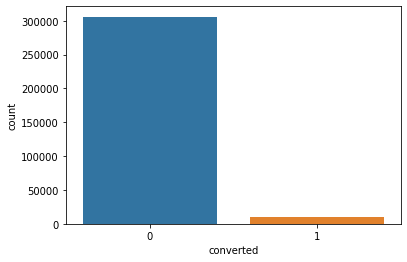

In [5]:
sns.countplot(raw_dat["converted"])

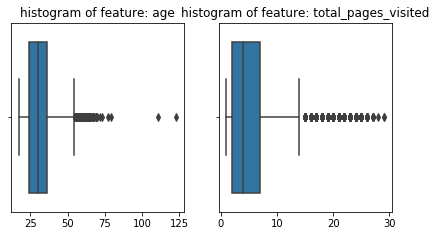

In [17]:
#### outlier analysis
def box_plot(dat,conti_colnames):
    plt.figure(figsize=(18,4*4))
    gs = gridspec.GridSpec(4,5)
    cols = conti_colnames
    ## get the colnames of numerical data
    df = dat[cols]
    for i, cn in enumerate(df):
        ax = plt.subplot(gs[i])
        sns.boxplot(df[cn])
        ax.set_xlabel('')
        ax.set_title('histogram of feature: ' + cn)
    plt.show()
box_plot(raw_dat, raw_dat.iloc[:,[1,4]].columns)

In [10]:
## turn categorical data into dummy variables
cate_features = ['country','new_user','source']
data = raw_dat
for i in cate_features:
    dummy = pd.get_dummies(data[i])
    data = data.drop(i,axis = 1)
    data = pd.concat([data,dummy], axis = 1)

In [19]:
data.head(6)

,age,total_pages_visited,converted,China,Germany,UK,US,0,1,Ads,Direct,Seo
0,25,1,0,0,0,1,0,0,1,1,0,0
1,23,5,0,0,0,0,1,0,1,0,0,1
2,28,4,0,0,0,0,1,0,1,0,0,1
3,39,5,0,1,0,0,0,0,1,0,0,1
4,30,6,0,0,0,0,1,0,1,0,0,1
5,31,1,0,0,0,0,1,1,0,0,0,1


In [21]:
continueous_dat = ['age','total_pages_visited']
for i in continueous_dat:
    x = data[[i]].values.astype(float)
    data = data.drop(i,axis = 1)
    StandardScaler = preprocessing.StandardScaler()
    x_scaled = StandardScaler.fit_transform(x)
    df_norm = pd.DataFrame(x_scaled,columns=[i])
    data = pd.concat([data,df_norm], axis = 1)

In [22]:
data.head(6)

,converted,China,Germany,UK,US,0,1,Ads,Direct,Seo,age,total_pages_visited
0,0,0,0,1,0,0,1,1,0,0,-0.673356,-1.159190
1,0,0,0,0,1,0,1,0,0,1,-0.915142,0.038021
2,0,0,0,0,1,0,1,0,0,1,-0.310677,-0.261281
3,0,1,0,0,0,0,1,0,0,1,1.019144,0.038021
4,0,0,0,0,1,0,1,0,0,1,-0.068892,0.337324
5,0,0,0,0,1,1,0,0,0,1,0.052001,-1.159190


In [25]:
xTrain, xTest, yTrain, yTest = train_test_split(data.iloc[:,1:],data.iloc[:,0], test_size = 0.2, random_state = 0)

In [26]:
train_dat = lgb.Dataset(xTrain, label= yTrain)

In [27]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [28]:
space = {
    'max_depth': hp.choice('max_depth', range(20,30)),
    'feature_fraction': hp.uniform('feature_fraction', 0.8,1.0),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.8, 1.0),
    'num_leaves': hp.choice('num_leaves',range(10,20)),
    'min_split_gain': hp.uniform('min_split_gain', 0.01,0.1),
    'min_child_weight': hp.choice('min_child_weight', range(10,20))
}
## The range I chose here can be wider. The range in this demo is just for saving time
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'feature_fraction': params['feature_fraction'],
        'bagging_fraction': params['bagging_fraction'],
        'num_leaves': int(params['num_leaves']),
        'min_split_gain': params['min_split_gain'],
        'min_child_weight': params['min_child_weight']
    }
    
    clf = lgb.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        boosting_type= 'gbdt',
        objective='binary',
        **params
    )
    
    score = cross_val_score(clf, xTrain, yTrain,scoring='roc_auc', cv=StratifiedKFold()).mean()
    print("AUC {:.3f} params {}".format(score, params))
    return 1-score

In [31]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
           trials = trials)

AUC 0.985 params {'max_depth': 21, 'feature_fraction': 0.8997694303530187, 'bagging_fraction': 0.8313003823531788, 'num_leaves': 10, 'min_split_gain': 0.07108548921706552, 'min_child_weight': 17}
AUC 0.986 params {'max_depth': 29, 'feature_fraction': 0.823059928121363, 'bagging_fraction': 0.8397513435859474, 'num_leaves': 14, 'min_split_gain': 0.03636293901002066, 'min_child_weight': 11}
AUC 0.985 params {'max_depth': 24, 'feature_fraction': 0.9246043983837341, 'bagging_fraction': 0.9910696495149813, 'num_leaves': 11, 'min_split_gain': 0.037787547447704045, 'min_child_weight': 10}
AUC 0.986 params {'max_depth': 28, 'feature_fraction': 0.8615371456993133, 'bagging_fraction': 0.9954152006879056, 'num_leaves': 18, 'min_split_gain': 0.033393538682598006, 'min_child_weight': 17}
AUC 0.986 params {'max_depth': 25, 'feature_fraction': 0.9230349217265923, 'bagging_fraction': 0.9757439994224344, 'num_leaves': 12, 'min_split_gain': 0.09079959708593596, 'min_child_weight': 13}
AUC 0.986 params {'

In [32]:
print(best)

{'bagging_fraction': 0.8397513435859474, 'feature_fraction': 0.823059928121363, 'max_depth': 9, 'min_child_weight': 1, 'min_split_gain': 0.03636293901002066, 'num_leaves': 4}


In [33]:
num_round = 2000
bst = lgb.train(best, train_dat, num_round)

In [34]:
ypred = bst.predict(xTest, num_iteration=bst.best_iteration)

In [36]:
Y_pred = []
for i in ypred:
    if i <=0.5:
        Y_pred.append(0)
    else:
        Y_pred.append(1)

In [37]:
from sklearn import metrics

In [38]:
metrics.roc_auc_score(yTest,ypred)

0.9229120849303507

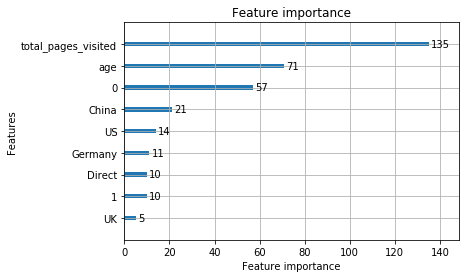

In [39]:
lgb.plot_importance(bst,max_num_features=20)